# CNN Classification with MPQA Dataset
<hr>

We will build a text classification model using CNN model on the MPQA Dataset. Since there is no standard train/test split for this dataset, we will use 10-Fold Cross Validation (CV). 

## Load the library

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import random
from nltk.corpus import stopwords, twitter_samples
# from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import KFold
from nltk.stem import PorterStemmer
from string import punctuation
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
import time

%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False
# nltk.download('twitter_samples')

## Load the Dataset

In [4]:
corpus = pd.read_pickle('../../0_data/MPQA/MPQA.pkl')
corpus.label = corpus.label.astype(int)
print(corpus.shape)
corpus

(10606, 3)


sentence  label  split
0              complaining      0  train
1       failing to support      0  train
2        desperately needs      0  train
3      many years of decay      0  train
4             no quick fix      0  train
...                    ...    ...    ...
10601                urged      1  train
10602       strictly abide      1  train
10603                 hope      1  train
10604       strictly abide      1  train
10605                           1  train

[10606 rows x 3 columns]

In [5]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10606 entries, 0 to 10605
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  10606 non-null  object
 1   label     10606 non-null  int32 
 2   split     10606 non-null  object
dtypes: int32(1), object(2)
memory usage: 207.3+ KB


In [6]:
corpus.groupby( by='label').count()

sentence  split
label                 
0          7294   7294
1          3312   3312

In [7]:
# Separate the sentences and the labels
sentences, labels = list(corpus.sentence), list(corpus.label)

## Raw Number of Vocabulary

In [8]:
# Build the raw vocobulary for first inspection
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
vocab_raw = tokenizer.word_index
print('\nThe vocabulary size: {}\n'.format(len(vocab_raw)))
print(vocab_raw)


The vocabulary size: 6234

{'the': 1, 'of': 2, 'to': 3, 'a': 4, 'and': 5, 'not': 6, 'is': 7, 'in': 8, 'be': 9, 'has': 10, 'for': 11, 'will': 12, 'have': 13, 'are': 14, 'support': 15, 'would': 16, 'was': 17, 'it': 18, 'evil': 19, 'on': 20, 'with': 21, 'as': 22, 'an': 23, 'no': 24, 'more': 25, "'s": 26, 'that': 27, 'its': 28, 'axis': 29, 'against': 30, 'can': 31, 'his': 32, 'by': 33, 'their': 34, 'want': 35, 'had': 36, 'do': 37, 'all': 38, 'were': 39, 'been': 40, 'rights': 41, 'one': 42, 'very': 43, 'war': 44, 'out': 45, 'called': 46, 'only': 47, 'so': 48, 'could': 49, 'at': 50, 'this': 51, 'human': 52, 'good': 53, 'us': 54, 'peace': 55, 'should': 56, 'most': 57, 'up': 58, 'free': 59, 'concern': 60, 'they': 61, 'world': 62, 'fair': 63, 'criticism': 64, 'from': 65, "n't": 66, 'does': 67, 'even': 68, 'or': 69, 'any': 70, 'accused': 71, 'hope': 72, 'if': 73, 'people': 74, 'than': 75, 'like': 76, 'such': 77, 'way': 78, 'warned': 79, 'expressed': 80, 'but': 81, 'legitimate': 82, 'just': 83, 

<!--## Split Dataset-->

# Data Preprocessing
<hr>

## Define `clean_doc` function

In [9]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stemmer = PorterStemmer()
    
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
#     tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) >= 1]
    # Stem the token
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

## Develop Vocabulary

A part of preparing text for text classification involves defining and tailoring the vocabulary of words supported by the model. **We can do this by loading all of the documents in the dataset and building a set of words.**

The larger the vocabulary, the more sparse the representation of each word or document. So, we may decide to support all of these words, or perhaps discard some. The final chosen vocabulary can then be saved to a file for later use, such as filtering words in new documents in the future.

We can use `Counter` class and create an instance called `vocab` as follows:

In [10]:
from collections import Counter

vocab = Counter()

def add_doc_to_vocab(docs, vocab):
    '''
    input:
        docs: a list of sentences (docs)
        vocab: a vocabulary dictionary
    output:
        return an updated vocabulary
    '''
    for doc in docs:
        tokens = clean_doc(doc)
        vocab.update(tokens)
    return vocab

In [11]:
# Example
add_doc_to_vocab(sentences, vocab)
print(len(vocab))
vocab

4163


Counter({'complain': 13,
         'fail': 36,
         'support': 264,
         'desper': 19,
         'need': 17,
         'mani': 20,
         'year': 21,
         'decay': 2,
         'quick': 5,
         'fix': 3,
         'happi': 17,
         'long': 28,
         'pain': 9,
         'nobodi': 3,
         'complic': 8,
         'process': 8,
         'decad': 4,
         'dramat': 6,
         'econom': 22,
         'declin': 14,
         'suffer': 26,
         'would': 188,
         'sure': 10,
         'higher': 5,
         'still': 30,
         'forbidden': 1,
         'intox': 1,
         'far': 32,
         'perfect': 2,
         'sour': 1,
         'relat': 12,
         'fell': 3,
         'mount': 3,
         'rivalri': 1,
         'hostil': 14,
         'nation': 42,
         'accus': 85,
         'bow': 6,
         'total': 18,
         'depend': 4,
         'lose': 10,
         'control': 13,
         'warn': 76,
         'heel': 1,
         'pressur': 8,
         'knee':

In [12]:
vocab.items()

dict_items([('complain', 13), ('fail', 36), ('support', 264), ('desper', 19), ('need', 17), ('mani', 20), ('year', 21), ('decay', 2), ('quick', 5), ('fix', 3), ('happi', 17), ('long', 28), ('pain', 9), ('nobodi', 3), ('complic', 8), ('process', 8), ('decad', 4), ('dramat', 6), ('econom', 22), ('declin', 14), ('suffer', 26), ('would', 188), ('sure', 10), ('higher', 5), ('still', 30), ('forbidden', 1), ('intox', 1), ('far', 32), ('perfect', 2), ('sour', 1), ('relat', 12), ('fell', 3), ('mount', 3), ('rivalri', 1), ('hostil', 14), ('nation', 42), ('accus', 85), ('bow', 6), ('total', 18), ('depend', 4), ('lose', 10), ('control', 13), ('warn', 76), ('heel', 1), ('pressur', 8), ('knee', 1), ('militari', 14), ('adventur', 3), ('boost', 3), ('threaten', 52), ('heavili', 4), ('arm', 6), ('place', 18), ('world', 59), ('danger', 43), ('flashpoint', 1), ('want', 162), ('avoid', 13), ('superfici', 2), ('exercis', 7), ('mere', 19), ('speak', 8), ('deep', 9), ('diverg', 2), ('neg', 11), ('bias', 12),

In [13]:
#########################
# Define the vocabulary #
#########################

from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stemmer = PorterStemmer()
    
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) >= 1]
    # Stem the token
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

def add_doc_to_vocab(docs, vocab):
    '''
    input:
        docs: a list of sentences (docs)
        vocab: a vocabulary dictionary
    output:
        return an updated vocabulary
    '''
    for doc in docs:
        tokens = clean_doc(doc)
        vocab.update(tokens)
    
    return vocab
        

# prepare cross validation with 10 splits and shuffle = True
kfold = KFold(10, True)

# Separate the sentences and the labels
sentences, labels = list(corpus.sentence), list(corpus.label)

acc_list = []

# kfold.split() will return set indices for each split
for train, test in kfold.split(sentences):
    # Instantiate a vocab object
    vocab = Counter()
    
    train_x, test_x = [], []
    train_y, test_y = [], []
    
    for i in train:
        train_x.append(sentences[i])
        train_y.append(labels[i])
    
    for i in test:
        test_x.append(sentences[i])
        test_y.append(labels[i])
    
    vocab = add_doc_to_vocab(train_x, vocab)
    print(len(train_x), len(test_x))
    print(len(vocab))

C:\Users\Diardano Raihan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass shuffle=True as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


9545 1061
3972
9545 1061
3978
9545 1061
3975
9545 1061
3983
9545 1061
3984
9545 1061
3959
9546 1060
3964
9546 1060
3975
9546 1060
4005
9546 1060
3959


<dir>

# Bag-of-Words Representation
<hr>

Once we define our vocab obtained from the training data, we need to **convert each review into a representation that we can feed to a Multilayer Perceptron Model.**

As a reminder, here are the summary what we will do:
- extract features from the text so the text input can be used with ML algorithms like neural networks
- we do by converting the text into a vector representation. The larger the vocab, the longer the representation.
- we will score the words in a document inside the vector. These scores are placed in the corresponding location in the vector representation.

In [14]:
def doc_to_line(doc):
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [token for token in tokens if token in vocab]
    line = ' '.join([token for token in tokens])
    return line

In [15]:
def clean_docs(docs):
    lines = []
    for doc in docs:
        line = doc_to_line(doc)
        lines.append(line)
    return lines

In [16]:
print(sentences[:5])
clean_sentences = clean_docs(sentences[:5])
print()
print( clean_sentences)

['complaining', 'failing to support', 'desperately needs', 'many years of decay', 'no quick fix']

['complain', 'fail support', 'desper need', 'mani year decay', 'quick fix']


## Bag-of-Words Vectors

We will use the **Keras API** to **convert sentences to encoded document vectors**. Although the `Tokenizer` class from TF Keras provides cleaning and vocab definition, it's better we do this ourselves so that we know exactly we are doing.

In [17]:
def create_tokenizer(sentence):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

This process determines a consistent way to **convert the vocabulary to a fixed-length vector**, which is the total number of words in the vocabulary `vocab`. 

Next, documents can then be encoded using the Tokenizer by calling `texts_to_matrix()`. 

The function takes both a list of documents to encode and an encoding mode, which is the method used to score words in the document. Here we specify **freq** to score words based on their frequency in the document. 

This can be used to encode the loaded training and test data, for example:

`Xtrain = tokenizer.texts_to_matrix(train_docs, mode='freq')`

`Xtest = tokenizer.texts_to_matrix(test_docs, mode='freq')`

In [18]:
#########################
# Define the vocabulary #
#########################

from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stemmer = PorterStemmer()
    
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) >= 1]
    # Stem the token
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

def add_doc_to_vocab(docs, vocab):
    '''
    input:
        docs: a list of sentences (docs)
        vocab: a vocabulary dictionary
    output:
        return an updated vocabulary
    '''
    for doc in docs:
        tokens = clean_doc(doc)
        vocab.update(tokens)
    return vocab
        
def doc_to_line(doc, vocab):
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [token for token in tokens if token in vocab]
    line = ' '.join(tokens)
    return line

def clean_docs(docs, vocab):
    lines = []
    for doc in docs:
        line = doc_to_line(doc, vocab)
        lines.append(line)
    return lines

def create_tokenizer(sentences):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    return tokenizer

# prepare cross validation with 10 splits and shuffle = True
kfold = KFold(10, True)

# Separate the sentences and the labels
sentences, labels = list(corpus.sentence), list(corpus.label)

acc_list = []

# kfold.split() will return set indices for each split
for train, test in kfold.split(sentences):
    # Instantiate a vocab object
    vocab = Counter()
    
    train_x, test_x = [], []
    train_y, test_y = [], []
    
    for i in train:
        train_x.append(sentences[i])
        train_y.append(labels[i])
    
    for i in test:
        test_x.append(sentences[i])
        test_y.append(labels[i])
    
    # Turn the labels into a numpy array
    train_y = np.array(train_y)
    test_y = np.array(test_y)
    
    # Define a vocabulary for each fold
    vocab = add_doc_to_vocab(train_x, vocab)
    print('The number of vocab: ', len(vocab))
    
    # Clean the sentences
    train_x = clean_docs(train_x, vocab)
    test_x = clean_docs(test_x, vocab)
    
    # Define the tokenizer
    tokenizer = create_tokenizer(train_x)
    
    # encode data using freq mode
    Xtrain = tokenizer.texts_to_matrix(train_x, mode='freq')
    Xtest = tokenizer.texts_to_matrix(test_x, mode='freq')
   

print(Xtrain.shape)
print(train_x[0])
print(Xtrain[0])
print(Xtest.shape)
print(test_x[0])
print(Xtest[0])

The number of vocab:  3979
The number of vocab:  3979
The number of vocab:  3955
The number of vocab:  3963
The number of vocab:  3985
The number of vocab:  4002
The number of vocab:  3970
The number of vocab:  3971
The number of vocab:  3962
The number of vocab:  3980
(9546, 3981)
complain
[0. 0. 0. ... 0. 0. 0.]
(1060, 3981)
long pain
[0. 0. 0. ... 0. 0. 0.]


# Training and Testing the Model

## CNN Model

Now, we will build Convolutional Neural Network (CNN) models to classify encoded documents as either positive or negative.

The model takes inspiration from `CNN for Sentence Classification` by *Yoon Kim*.

Now, we will define our CNN model as follows:
- One Conv layer with 100 filters, kernel size 5, and relu activation function;
- One MaxPool layer with pool size = 2;
- One Dropout layer after flattened;
- Optimizer: Adam (The best learning algorithm so far)
- Loss function: binary cross-entropy (suited for binary classification problem)

**Note**: 
- The whole purpose of dropout layers is to tackle the problem of over-fitting and to introduce generalization to the model. Hence it is advisable to keep dropout parameter near 0.5 in hidden layers. 
- https://missinglink.ai/guides/keras/keras-conv1d-working-1d-convolutional-neural-networks-keras/

In [19]:
def train_cnn(train_x, train_y, batch_size = 50, epochs = 10, verbose =2):
    
    n_words = train_x.shape[1]
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=100, kernel_size=5, activation='relu', input_shape=(n_words,1)),
        tf.keras.layers.MaxPool1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0,5),
        tf.keras.layers.Dense( units=1, activation='sigmoid')
    ])
    
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.fit(train_x, train_y, batch_size, epochs, verbose)
    return model

## Train and Test the Model

In [20]:
#########################
# Define the vocabulary #
#########################

from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stemmer = PorterStemmer()
    
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) >= 1]
    # Stem the token
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

def add_doc_to_vocab(docs, vocab):
    '''
    input:
        docs: a list of sentences (docs)
        vocab: a vocabulary dictionary
    output:
        return an updated vocabulary
    '''
    for doc in docs:
        tokens = clean_doc(doc)
        vocab.update(tokens)
    return vocab
        
def doc_to_line(doc, vocab):
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [token for token in tokens if token in vocab]
    line = ' '.join(tokens)
    return line

def clean_docs(docs, vocab):
    lines = []
    for doc in docs:
        line = doc_to_line(doc, vocab)
        lines.append(line)
    return lines

def create_tokenizer(sentences):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    return tokenizer

def train_cnn(train_x, train_y, batch_size = 50, epochs = 10, verbose =2):
    
    n_words = train_x.shape[1]
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=100, kernel_size=5, activation='relu', input_shape=(n_words,1)),
        tf.keras.layers.MaxPool1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=1, activation='sigmoid')
    ])
    
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.fit(train_x, train_y, batch_size, epochs, verbose)
    return model

# prepare cross validation with 10 splits and shuffle = True
kfold = KFold(10, True)

# Separate the sentences and the labels
sentences, labels = list(corpus.sentence), list(corpus.label)

acc_list = []

# kfold.split() will return set indices for each split
for train, test in kfold.split(sentences):
    # Instantiate a vocab object
    vocab = Counter()
    
    train_x, test_x = [], []
    train_y, test_y = [], []
    
    for i in train:
        train_x.append(sentences[i])
        train_y.append(labels[i])
    
    for i in test:
        test_x.append(sentences[i])
        test_y.append(labels[i])
    
    # Turn the labels into a numpy array
    train_y = np.array(train_y)
    test_y = np.array(test_y)
    
    # Define a vocabulary for each fold
    vocab = add_doc_to_vocab(train_x, vocab)
    # print('The number of vocab: ', len(vocab))
    
    # Clean the sentences
    train_x = clean_docs(train_x, vocab)
    test_x = clean_docs(test_x, vocab)
    
    # Define the tokenizer
    tokenizer = create_tokenizer(train_x)
    
    # encode data using freq mode
    Xtrain = tokenizer.texts_to_matrix(train_x, mode='freq')
    Xtest = tokenizer.texts_to_matrix(test_x, mode='freq')
    
    Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], 1))
    Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], 1))

    print(Xtrain.shape)
    print(Xtest.shape)
    # train the model
    model = train_cnn(Xtrain, train_y)
    
    # evaluate the model
    loss, acc = model.evaluate(Xtest, test_y, verbose=0)
    print('Test Accuracy: {}'.format(acc*100))
    
    acc_list.append(acc)

acc_list = np.array(acc_list)
print()
print('The test ccuracy for each training:\n{}'.format(acc_list))
print('The mean of the test accuracy: ', acc_list.mean())

(9545, 3995, 1)
(1061, 3995, 1)
Epoch 1/10
191/191 - 161s - loss: 0.5769 - accuracy: 0.7121
Epoch 2/10
191/191 - 212s - loss: 0.4060 - accuracy: 0.8328
Epoch 3/10
191/191 - 211s - loss: 0.3221 - accuracy: 0.8703
Epoch 4/10
191/191 - 209s - loss: 0.2788 - accuracy: 0.8886
Epoch 5/10
191/191 - 197s - loss: 0.2569 - accuracy: 0.8992
Epoch 6/10
191/191 - 208s - loss: 0.2392 - accuracy: 0.9029
Epoch 7/10
191/191 - 291s - loss: 0.2283 - accuracy: 0.9071
Epoch 8/10
191/191 - 328s - loss: 0.2216 - accuracy: 0.9099
Epoch 9/10
191/191 - 308s - loss: 0.2166 - accuracy: 0.9109
Epoch 10/10
191/191 - 328s - loss: 0.2126 - accuracy: 0.9123
Test Accuracy: 81.80961608886719
(9545, 3938, 1)
(1061, 3938, 1)
Epoch 1/10
191/191 - 317s - loss: 0.5618 - accuracy: 0.7216
Epoch 2/10
191/191 - 314s - loss: 0.4013 - accuracy: 0.8330
Epoch 3/10
191/191 - 328s - loss: 0.3257 - accuracy: 0.8704
Epoch 4/10
191/191 - 321s - loss: 0.2879 - accuracy: 0.8847
Epoch 5/10
191/191 - 319s - loss: 0.2642 - accuracy: 0.8941
Ep

In [21]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 3972, 100)         600       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 1986, 100)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 198600)            0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 198600)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 198601    
Total params: 199,201
Trainable params: 199,201
Non-trainable params: 0
_________________________________________________________________


# Comparing the Word Scoring Methods

When we use `text_to_matrix()` function, we are given 4 different methods for scoring words:
- `binary`: words are marked as 1 (present) or 0 (absent)
- `count`: words are counted based on their occurrence (integer)
- `tfidf`: words are scored  based on their frequency of occurrence in their own document, but also are being penalized if they are common across  all documents
- `freq`: wrods are scored based on their frequency of occurrence in their own document

In [22]:
# prepare bag-of-words encoding of docs
def prepare_data(train_docs, test_docs, mode):
    # create the tokenizer
    tokenizer = Tokenizer()
    # fit the tokenizer on the documents
    tokenizer.fit_on_texts(train_docs)
    # encode training data set
    Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
    # encode test data set
    Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
    return Xtrain, Xtest

In [23]:
#########################
# Define the vocabulary #
#########################

from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stemmer = PorterStemmer()
    
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) >= 1]
    # Stem the token
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

def add_doc_to_vocab(docs, vocab):
    '''
    input:
        docs: a list of sentences (docs)
        vocab: a vocabulary dictionary
    output:
        return an updated vocabulary
    '''
    for doc in docs:
        tokens = clean_doc(doc)
        vocab.update(tokens)
    return vocab
        
def doc_to_line(doc, vocab):
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [token for token in tokens if token in vocab]
    line = ' '.join(tokens)
    return line

def clean_docs(docs, vocab):
    lines = []
    for doc in docs:
        line = doc_to_line(doc, vocab)
        lines.append(line)
    return lines

# prepare bag-of-words encoding of docs
def prepare_data(train_docs, test_docs, mode):
    # create the tokenizer
    tokenizer = Tokenizer()
    # fit the tokenizer on the documents
    tokenizer.fit_on_texts(train_docs)
    # encode training data set
    Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
    # encode test data set
    Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
    return Xtrain, Xtest

def train_cnn(train_x, train_y, batch_size = 50, epochs = 10, verbose =2):
    
    n_words = train_x.shape[1]
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=100, kernel_size=5, activation='relu', input_shape=(n_words,1)),
        tf.keras.layers.MaxPool1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense( units=1, activation='sigmoid')
    ])
    
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    model.fit(train_x, train_y, batch_size, epochs, verbose)
    return model

# prepare cross validation with 10 splits and shuffle = True
kfold = KFold(10, True)

# Separate the sentences and the labels
sentences, labels = list(corpus.sentence), list(corpus.label)

# Run Experiment of 4 different modes
modes = ['binary', 'count', 'tfidf', 'freq']
results = pd.DataFrame()

for mode in modes:
    print('mode: ', mode)
    acc_list = []
    
    # kfold.split() will return set indices for each split
    for train, test in kfold.split(sentences):
        # Instantiate a vocab object
        vocab = Counter()

        train_x, test_x = [], []
        train_y, test_y = [], []

        for i in train:
            train_x.append(sentences[i])
            train_y.append(labels[i])

        for i in test:
            test_x.append(sentences[i])
            test_y.append(labels[i])

        # Turn the labels into a numpy array
        train_y = np.array(train_y)
        test_y = np.array(test_y)

        # Define a vocabulary for each fold
        vocab = add_doc_to_vocab(train_x, vocab)
        # print('The number of vocab: ', len(vocab))

        # Clean the sentences
        train_x = clean_docs(train_x, vocab)
        test_x = clean_docs(test_x, vocab)

        # encode data using freq mode
        Xtrain, Xtest = prepare_data(train_x, test_x, mode)
        
        Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], 1))
        Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], 1))

        # train the model
        model = train_cnn(Xtrain, train_y, verbose=0)

        # evaluate the model
        loss, acc = model.evaluate(Xtest, test_y, verbose=0)
        print('Test Accuracy: {}'.format(acc*100))

        acc_list.append(acc)
    
    results[mode] = acc_list
    acc_list = np.array(acc_list)
    print('The test ccuracy for each training:\n{}'.format(acc_list))
    print('The mean of the test accuracy: ', acc_list.mean())
    print()

print(results)

mode:  binary
Test Accuracy: 84.26012992858887
Test Accuracy: 83.41187834739685
Test Accuracy: 82.09236860275269
Test Accuracy: 83.12912583351135
Test Accuracy: 84.82563495635986
Test Accuracy: 86.23939752578735
Test Accuracy: 84.1509461402893
Test Accuracy: 83.11320543289185
Test Accuracy: 85.18868088722229
Test Accuracy: 83.67924690246582
The test ccuracy for each training:
[0.8426013  0.83411878 0.82092369 0.83129126 0.84825635 0.86239398
 0.84150946 0.83113205 0.85188681 0.83679247]
The mean of the test accuracy:  0.8400906145572662

mode:  count
Test Accuracy: 84.91988778114319
Test Accuracy: 82.6578676700592
Test Accuracy: 84.54288244247437
Test Accuracy: 83.7888777256012
Test Accuracy: 82.75212049484253
Test Accuracy: 85.29688715934753
Test Accuracy: 82.92452692985535
Test Accuracy: 84.05660390853882
Test Accuracy: 82.26414918899536
Test Accuracy: 85.37735939025879
The test ccuracy for each training:
[0.84919888 0.82657868 0.84542882 0.83788878 0.8275212  0.85296887
 0.82924527 

In [24]:
results

binary     count     tfidf      freq
0  0.842601  0.849199  0.819039  0.827521
1  0.834119  0.826579  0.832234  0.836946
2  0.820924  0.845429  0.832234  0.852969
3  0.831291  0.837889  0.842601  0.852969
4  0.848256  0.827521  0.812441  0.834119
5  0.862394  0.852969  0.838831  0.836004
6  0.841509  0.829245  0.833962  0.834906
7  0.831132  0.840566  0.842453  0.837736
8  0.851887  0.822641  0.832075  0.833962
9  0.836792  0.853774  0.846226  0.828302

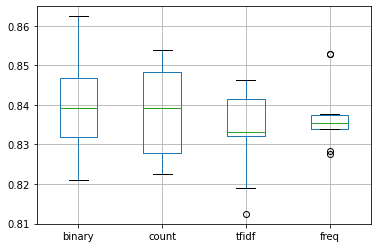

In [25]:
import seaborn as sns

results.boxplot()
plt.show()

In [26]:
results.describe()

binary      count      tfidf       freq
count  10.000000  10.000000  10.000000  10.000000
mean    0.840091   0.838581   0.833210   0.837543
std     0.011941   0.011593   0.010597   0.008794
min     0.820924   0.822641   0.812441   0.827521
25%     0.831998   0.827952   0.832115   0.834001
50%     0.839151   0.839227   0.833098   0.835455
75%     0.846843   0.848256   0.841547   0.837538
max     0.862394   0.853774   0.846226   0.852969